In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import numpy as np

In [103]:
df=pd.read_csv("Warehouse_and_Retail_Sales.csv")
df.head(1)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.0,0.0,2.0


In [104]:
#Checking the Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


In [105]:
# checking the missing items
df.isnull().sum()

YEAR                  0
MONTH                 0
SUPPLIER            167
ITEM CODE             0
ITEM DESCRIPTION      0
ITEM TYPE             1
RETAIL SALES          3
RETAIL TRANSFERS      0
WAREHOUSE SALES       0
dtype: int64

### As the missing data is very small comparing to the large data size of 300000+ rows so filled Suppliers with unknown, ITEM TYPE with values for similar Item type and RETAIL SALES  with 0

In [106]:
# Filter rows where ITEM DESCRIPTION is 'JIGGER MEASURE SHOT GLASS' and Check which of those rows have missing Supplier
jigger_rows=df[df["ITEM DESCRIPTION"]=="JIGGER MEASURE SHOT GLASS"]
missing=jigger_rows[jigger_rows["SUPPLIER"].isnull()]
print("Rows with missing supplier for JIGGER MEASURE SHOT GLASS:",missing)

Rows with missing supplier for JIGGER MEASURE SHOT GLASS:         YEAR  MONTH SUPPLIER ITEM CODE           ITEM DESCRIPTION  \
106     2020      1      NaN       107  JIGGER MEASURE SHOT GLASS   
12118   2020      7      NaN       107  JIGGER MEASURE SHOT GLASS   
23348   2020      3      NaN       107  JIGGER MEASURE SHOT GLASS   
157559  2019      1      NaN       107  JIGGER MEASURE SHOT GLASS   
169940  2019      2      NaN       107  JIGGER MEASURE SHOT GLASS   
182241  2019      3      NaN       107  JIGGER MEASURE SHOT GLASS   
194916  2019      4      NaN       107  JIGGER MEASURE SHOT GLASS   
207650  2019      5      NaN       107  JIGGER MEASURE SHOT GLASS   
220600  2019      6      NaN       107  JIGGER MEASURE SHOT GLASS   
232920  2019      7      NaN       107  JIGGER MEASURE SHOT GLASS   
245423  2019      8      NaN       107  JIGGER MEASURE SHOT GLASS   
257836  2019      9      NaN       107  JIGGER MEASURE SHOT GLASS   
270256  2019     10      NaN       107  JIGGE

In [107]:
# mapping from ITEM CODE to SUPPLIER (where supplier is not missing)
suppliers=df.dropna(subset=["SUPPLIER"]).groupby("ITEM CODE")["SUPPLIER"].first()
suppliers

ITEM CODE
100002              RELIABLE CHURCHILL LLLP
100007                CONSTANTINE WINES INC
100008                CONSTANTINE WINES INC
100009    REPUBLIC NATIONAL DISTRIBUTING CO
100011              INTERBALT PRODUCTS CORP
                        ...                
9989                    KATCEF BROTHERS INC
9997                     ANHEUSER BUSCH INC
99970           COASTAL BREWING COMPANY LLC
99988               BOSTON BEER CORPORATION
99990               BOSTON BEER CORPORATION
Name: SUPPLIER, Length: 34040, dtype: object

In [108]:
# Fill missing supplier based on ITEM CODE
df["SUPPLIER"]=df.apply(lambda row: suppliers.get(row["ITEM CODE"], row["SUPPLIER"]), axis=1)

In [109]:
# fill with "Unknown"
df["SUPPLIER"]=df["SUPPLIER"].fillna("Unknown")

In [110]:
# verify the change
df[df["SUPPLIER"]=="Unknown"].head(1)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
106,2020,1,Unknown,107,JIGGER MEASURE SHOT GLASS,STR_SUPPLIES,14.69,18.0,0.0


In [111]:
# Filling the missing value in ITEM TYPE
itemtype=df.dropna(subset=["ITEM TYPE"]).groupby("SUPPLIER")["ITEM TYPE"].first()
itemtype

SUPPLIER
8 VINI INC                            WINE
A HARDY USA LTD                     LIQUOR
A I G WINE & SPIRITS                  WINE
A VINTNERS SELECTIONS                 WINE
A&E INC                               WINE
                                  ...     
WITH MALUS AFORETHOUGHT LLC           BEER
YOUNG WON TRADING INC                 BEER
YUENGLING BREWERY                     BEER
Z WINE GALLERY IMPORTS LLC            WINE
ZURENA LLC                     NON-ALCOHOL
Name: ITEM TYPE, Length: 394, dtype: object

In [112]:
df["ITEM TYPE"]=df.apply(lambda row: itemtype.get(row["SUPPLIER"],row["ITEM TYPE"]),axis=1)

In [113]:
#Filling the missing value in RETAIL SALES as 0
df["RETAIL SALES"]=df["RETAIL SALES"].fillna(0)

## Created a Net_Sales_Quantity column

In [114]:
# Create Net_Sales_Quantity
df["Total Net Sales Quanity"]=df["RETAIL SALES"]-df["RETAIL TRANSFERS"]+df["WAREHOUSE SALES"]

## Which supplier achieves the highest efficiency and its value

In [115]:
# Which supplier achieves the highest efficiency?
print(f"The highest efficiency supplier is {highest_efficiency_supplier} achieving {highest_efficiency_value}")

The highest efficiency supplier is CROWN IMPORTS achieving 24678.75


In [116]:
# Count of suppliers
suppliers_count=df.groupby("SUPPLIER")["ITEM CODE"].nunique()
suppliers_count

SUPPLIER
8 VINI INC                        2
A HARDY USA LTD                   1
A I G WINE & SPIRITS              6
A VINTNERS SELECTIONS          1084
A&E INC                          12
                               ... 
WITH MALUS AFORETHOUGHT LLC       2
YOUNG WON TRADING INC           158
YUENGLING BREWERY                30
Z WINE GALLERY IMPORTS LLC        9
ZURENA LLC                        1
Name: ITEM CODE, Length: 394, dtype: int64

In [117]:
# Sales per supplier
Sales_supplier=df.groupby("SUPPLIER")["Total Net Sales Quanity"].sum()
Sales_supplier

SUPPLIER
8 VINI INC                          1.53
A HARDY USA LTD                     0.56
A I G WINE & SPIRITS              205.32
A VINTNERS SELECTIONS            5879.55
A&E INC                            11.41
                                 ...    
WITH MALUS AFORETHOUGHT LLC        15.00
YOUNG WON TRADING INC            7169.30
YUENGLING BREWERY              134817.43
Z WINE GALLERY IMPORTS LLC         31.15
ZURENA LLC                          8.61
Name: Total Net Sales Quanity, Length: 394, dtype: float64

In [118]:
# Efficiency per supplier
efficiency=Sales_supplier/suppliers_count
efficiency

SUPPLIER
8 VINI INC                        0.765000
A HARDY USA LTD                   0.560000
A I G WINE & SPIRITS             34.220000
A VINTNERS SELECTIONS             5.423939
A&E INC                           0.950833
                                  ...     
WITH MALUS AFORETHOUGHT LLC       7.500000
YOUNG WON TRADING INC            45.375316
YUENGLING BREWERY              4493.914333
Z WINE GALLERY IMPORTS LLC        3.461111
ZURENA LLC                        8.610000
Length: 394, dtype: float64

In [119]:
# Highest Efficiency supplier
highest_efficiency_supplier=efficiency.idxmax()
highest_efficiency_supplier

'CROWN IMPORTS'

In [120]:
# Highest Efficiency value
highest_efficiency_value=round(efficiency.max(),2)
highest_efficiency_value

24678.75

## Create a Quarter column (Q1–Q3). Compare quarterly average Retail Sales. used groupby also made pivot table and barchart

In [121]:
print("Average Quarterly sales:",Avg_quarterly_sales)

Average Quarterly sales:   Quarter  RETAIL SALES
0      Q1      6.619190
1      Q2      7.039375
2      Q3      7.096956


In [122]:
# Created the columns using cut formula
df["Quarter"]=pd.cut(df["MONTH"],bins=[0,3,6,9],labels=["Q1","Q2","Q3"])

In [123]:
# Grouping the months by Retail Sales
Avg_quarterly_sales=df.groupby("Quarter")["RETAIL SALES"].mean().reset_index()
Avg_quarterly_sales

C:\Users\91996\AppData\Local\Temp\ipykernel_12132\398612118.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Avg_quarterly_sales=df.groupby("Quarter")["RETAIL SALES"].mean().reset_index()


,Quarter,RETAIL SALES
0,Q1,6.619190
1,Q2,7.039375
2,Q3,7.096956


In [124]:
# pivot table for Retails sales by Quarter
Quarterly_sales_pivot=pd.pivot_table(columns="Quarter",values="RETAIL SALES", data=df)
Quarterly_sales_pivot

C:\Users\91996\AppData\Local\Temp\ipykernel_12132\2778140142.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  Quarterly_sales_pivot=pd.pivot_table(columns="Quarter",values="RETAIL SALES", data=df)


Quarter,Q1,Q2,Q3
RETAIL SALES,6.61919,7.039375,7.096956


In [125]:
# Defining the colors as per quarter
colors={"Q1":"#1f77b4","Q2":"#ff7f0e","Q3":"#2ca02c"}

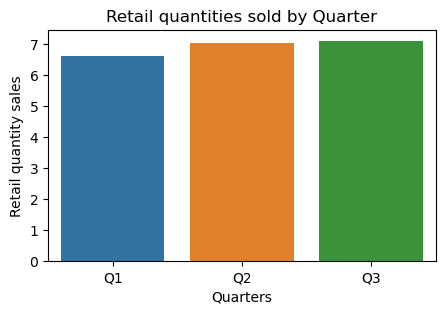

In [126]:
# Bar chart for Retails sales by Quarter
plt.figure(figsize=(5,3))
sns.barplot(data=Avg_quarterly_sales,x="Quarter",y="RETAIL SALES",hue="Quarter", palette=colors)
plt.title("Retail quantities sold by Quarter")
plt.xlabel("Quarters")
plt.ylabel("Retail quantity sales")
plt.savefig("Retail quantities sold by Quarter.png",dpi=300)

## calculate Item Typewize total Retail Sales, Warehouse Sales, and Transfers. Which item type dominates overall sales?

In [127]:
# Got the max item type and value
Item=itemtypesales["Overall sales"].idxmax()
Value=itemtypesales["Overall sales"].max()
print("Item", Item,"dominates the overall sales by",Value)

Item BEER dominates the overall sales by 4884125.76


In [128]:
#grouped and then added the sales quantity 
itemtypesales=df.groupby("ITEM TYPE")[["RETAIL SALES","WAREHOUSE SALES","RETAIL TRANSFERS",]].sum()
itemtypesales["Overall sales"]=(itemtypesales["RETAIL SALES"]-itemtypesales["RETAIL TRANSFERS"]+itemtypesales["WAREHOUSE SALES"])
itemtypesales

,RETAIL SALES,WAREHOUSE SALES,RETAIL TRANSFERS,Overall sales
ITEM TYPE,,,,
BEER,477030.32,4876444.37,469348.93,4884125.76
DUNNAGE,0.00,-92660.00,0.00,-92660.00
KEGS,143470.87,1597060.04,141613.41,1598917.50
LIQUOR,756020.17,397480.43,749632.34,403868.26
NON-ALCOHOL,6769.48,1085.00,6718.43,1136.05
STR_SUPPLIES,10339.02,-20646.00,11236.00,-21542.98
WINE,767269.51,1022992.44,755419.52,1034842.43


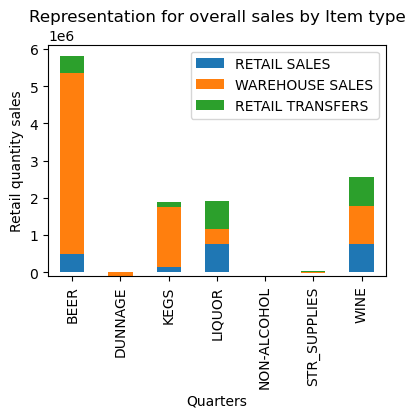

In [129]:
# Visual Representation for overall sales
itemtypesales[["RETAIL SALES","WAREHOUSE SALES","RETAIL TRANSFERS"]].plot(kind="bar",stacked=True,figsize=(5,3))
plt.title("Representation for overall sales by Item type")
plt.subplots_adjust(right=0.8)
plt.xlabel("Quarters")
plt.ylabel("Retail quantity sales")
plt.savefig("Visual Representation for overall sales.png",dpi=300, bbox_inches="tight", pad_inches=0.2)

##  compute month-over-month growth rate in Retail Sales. Identify the fastest-growing month.

In [132]:
Fastest_month=monthy_growth.idxmax()
Fastest_growth=round(monthy_growth.max(),2)
print(f"The month with highest growth is {Fastest_month} with growth rate of {Fastest_growth}")

The month with highest growth is 6 with growth rate of 98.22


In [131]:
monthwize=df.groupby("MONTH")["RETAIL SALES"].sum().sort_index()
monthy_growth=monthwize.pct_change()*100
monthy_growth

MONTH
1           NaN
2    -30.190123
3     22.755313
4    -58.554751
5     18.185276
6     98.221701
7     47.662948
8    -36.047983
9     43.291848
10   -30.319558
11    12.667191
12   -34.165473
Name: RETAIL SALES, dtype: float64

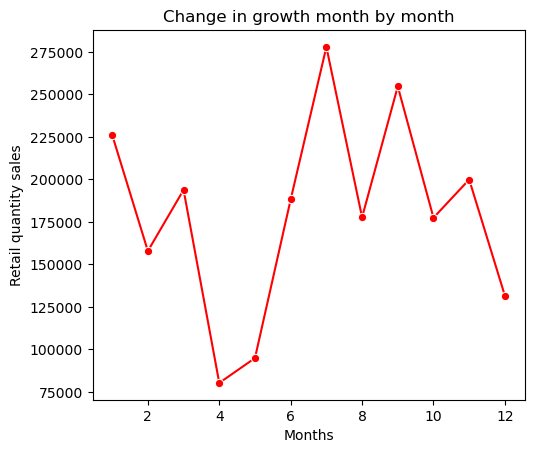

In [133]:
# Visual Representation for the change in growth month by month
growth_df=pd.DataFrame({"Month":monthwize.index,"Retail Sales":monthwize.values,"Growth Rate (%)":monthy_growth.values})
sns.lineplot(data=growth_df,x="Month",y="Retail Sales",marker="o",color="red")
plt.title("Change in growth month by month")
plt.subplots_adjust(right=0.8)
plt.xlabel("Months")
plt.ylabel("Retail quantity sales")
plt.savefig("Representation for the change in growth month by month.png",dpi=300, bbox_inches="tight", pad_inches=0.2)

## Supplier is most consistent by Retail Sales

In [134]:
suppliers=df.groupby("SUPPLIER")["RETAIL SALES"].var()
suppliers

SUPPLIER
8 VINI INC                        0.116261
A HARDY USA LTD                   0.001600
A I G WINE & SPIRITS              0.116060
A VINTNERS SELECTIONS             0.701736
A&E INC                           0.076692
                                  ...     
WITH MALUS AFORETHOUGHT LLC       0.000000
YOUNG WON TRADING INC            40.492425
YUENGLING BREWERY              9916.176520
Z WINE GALLERY IMPORTS LLC        0.303283
ZURENA LLC                        2.353082
Name: RETAIL SALES, Length: 394, dtype: float64

In [135]:
most_consistent=suppliers.idxmin()
most_consistent

'ARCHER ROOSE LLC'

In [136]:
lowest_consistent=suppliers.min()
lowest_consistent

0.0

## Performed a t-test comparing Retail Sales vs. Warehouse Sales. Is there a significant difference between them?

-- H0 - There is no significant difference between retail and wholesale sales
-- H1 - There is a significant difference between retail and wholesale sales

In [137]:
retail=df["RETAIL SALES"]
Warehouse=df["WAREHOUSE SALES"]

In [138]:
t_stats, p_value=ttest_ind(retail, Warehouse, equal_var=False)
print(t_stats)
print(p_value)

-40.24106491294047
0.0


In [139]:
alpha=0.05
if p_value<alpha:
    print("Reject H0: There is significant difference between retail and warehouse sales")
else:
    print("Fail to Reject H0: There is no significant difference between retail and warehouse sales")

Reject H0: There is significant difference between retail and warehouse sales


## Conduct a one-way ANOVA to test if warehouse sales differ across Item Types. Which item type drives the difference?

-- H0 - There is no significant difference between warehouse sale of various Item Types 
-- H1 - There is a significant difference between warehouse sale of various Item Types 

In [143]:
groups = [df[df['ITEM TYPE'] == it]['WAREHOUSE SALES'] for it in df['ITEM TYPE'].unique()]

In [144]:
f_stats, p_value=f_oneway(*groups)
p_value

np.float64(0.0)

In [145]:
alpha=0.05
if p_value<alpha:
    print("Reject H0: There is significant difference between warehouse sale of various Item Types ")
else:
    print("Fail to Reject H0: There is no significant difference between warehouse sale of various Item Types ")

Reject H0: There is significant difference between warehouse sale of various Item Types 


## Chi-Square test between Item Type and Supplier. Is supplier allocation independent of item type?

In [146]:
contingency=pd.crosstab(df["ITEM TYPE"],df["SUPPLIER"])
contingency

SUPPLIER,8 VINI INC,A HARDY USA LTD,A I G WINE & SPIRITS,A VINTNERS SELECTIONS,A&E INC,A&W BORDERS LLC,ADAMBA IMPORTS INTL,AIKO IMPORTERS INC,ALLAGASH BREWING COMPANY,ALLIED IMPORTERS USA LTD,...,WILLIAMS CORNER WINE,WILSON DANIELS LTD,WINE BRIDGE IMPORTS INC,WINEBOW INC,WINERY EXCHANGE INC,WITH MALUS AFORETHOUGHT LLC,YOUNG WON TRADING INC,YUENGLING BREWERY,Z WINE GALLERY IMPORTS LLC,ZURENA LLC
ITEM TYPE,,,,,,,,,,,,,,,,,,,,,
BEER,0,0,0,0,0,0,0,0,348,0,...,0,0,0,0,0,2,1955,461,0,0
DUNNAGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KEGS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LIQUOR,0,4,0,0,0,0,34,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NON-ALCOHOL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
STR_SUPPLIES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WINE,9,0,71,4650,42,7,0,67,0,33,...,50,47,370,19,15,0,0,0,44,0


In [147]:
chi2, p, dof, expected=chi2_contingency(contingency)
p

np.float64(0.0)

In [148]:
alpha=0.05
if p<alpha:
    print("Reject H0: Suppliers allocation is not independent of item types")
else:
    print("Fail to Reject H0: Suppliers allocation is independent of item types")

Reject H0: Suppliers allocation is not independent of item types


In [149]:
residuals = (contingency - expected) / (expected**0.5)
residuals

SUPPLIER,8 VINI INC,A HARDY USA LTD,A I G WINE & SPIRITS,A VINTNERS SELECTIONS,A&E INC,A&W BORDERS LLC,ADAMBA IMPORTS INTL,AIKO IMPORTERS INC,ALLAGASH BREWING COMPANY,ALLIED IMPORTERS USA LTD,...,WILLIAMS CORNER WINE,WILSON DANIELS LTD,WINE BRIDGE IMPORTS INC,WINEBOW INC,WINERY EXCHANGE INC,WITH MALUS AFORETHOUGHT LLC,YOUNG WON TRADING INC,YUENGLING BREWERY,Z WINE GALLERY IMPORTS LLC,ZURENA LLC
ITEM TYPE,,,,,,,,,,,,,,,,,,,,,
BEER,-1.088327,-0.725551,-3.056803,-24.738007,-2.351055,-0.959814,-2.115328,-2.969447,44.654794,-2.083988,...,-2.565212,-2.487065,-6.978131,-1.581303,-1.405024,3.385271,105.840491,51.395954,-2.406382,-1.739811
DUNNAGE,-0.026497,-0.017665,-0.074423,-0.602292,-0.057241,-0.023368,-0.051502,-0.072297,-0.164767,-0.050739,...,-0.062455,-0.060552,-0.169895,-0.038500,-0.034208,-0.012491,-0.390530,-0.189641,-0.058588,-0.042359
KEGS,-0.822360,-0.548240,-2.309777,-18.692495,-1.776501,-0.725253,-1.598381,-2.243769,-5.113643,-1.574700,...,-1.938321,-1.879272,-5.272804,-1.194862,-1.061662,-0.387664,-12.120323,-5.885607,-1.818307,-1.314634
LIQUOR,-1.397048,3.363405,-3.923912,-31.755324,-3.017969,-1.232081,9.805926,-3.811777,-8.687197,-2.675143,...,-3.292874,-3.192559,-8.957585,-2.029864,-1.803581,-0.658575,-20.590337,-9.998631,-3.088989,-2.233336
NON-ALCOHOL,-0.117383,-0.078256,-0.329697,-2.668161,-0.253577,-0.103522,-0.228152,-0.320275,-0.729920,-0.224772,...,-0.276675,-0.268247,-0.752638,-0.170554,-0.151541,-0.055335,-1.730051,-0.840110,-0.259545,122.380715
STR_SUPPLIES,-0.128905,-0.085937,-0.362058,-2.930055,-0.278467,-0.113684,-0.250547,-0.351712,-0.801565,-0.246835,...,-0.303833,-0.294577,-0.826514,-0.187295,-0.166416,-0.060767,-1.899864,-0.922571,-0.285020,-0.206069
WINE,1.692625,-1.513851,4.754103,38.473873,3.656487,1.492755,-4.413597,4.618244,-14.120264,3.241130,...,3.989555,3.868017,10.852762,2.459327,2.185169,-1.070454,-33.467754,-16.251881,3.742534,-3.630088


#### As there is Large negative residual → item type is under‑represented with that supplier.
This shows the supplier allocation is not independent, certain item types drive the difference.

### Create a line chart showing monthly Retail Sales trends. Highlight the peak month.

In [150]:
monthly_sales=df.groupby("MONTH")["RETAIL SALES"].sum()
monthly_sales
peak_month=monthly_sales.idxmax()
peak_sales=monthly_sales.max()
print(peak_month)
print(peak_sales)

7
277927.73


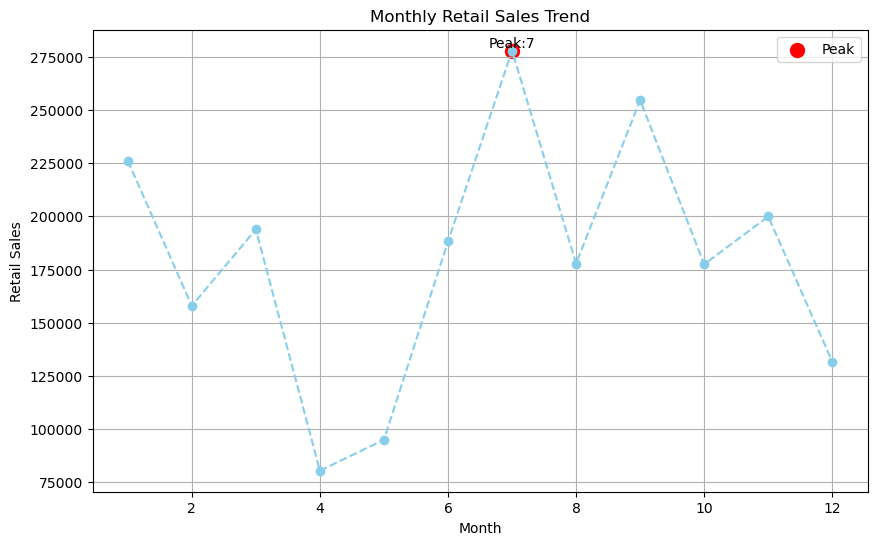

In [151]:
plt.figure(figsize=(10,6))
plt.plot(monthly_sales.index, monthly_sales.values, marker="o", linestyle="--", color="Skyblue")
plt.scatter(peak_month,peak_sales,color="red",s=100,label="Peak")
plt.text(peak_month,peak_sales, f'Peak:{peak_month}',ha="center",va="bottom",color="black")
plt.title("Monthly Retail Sales Trend") 
plt.xlabel("Month") 
plt.ylabel("Retail Sales") 
plt.legend() 
plt.grid(True)
plt.savefig("Monthly Retail Sales Trend.png", dpi=300)

### Build a stacked bar chart of Retail Sales, Warehouse Sales, and Transfers by Item Type. Which item type relies most on warehouse sales?

In [152]:
grouped_itemtypebysales=df.groupby("ITEM TYPE")[["RETAIL SALES","RETAIL TRANSFERS","WAREHOUSE SALES"]].sum()
grouped_itemtypebysales["Warehouse_proportion"]=grouped_itemtypebysales["WAREHOUSE SALES"]/(
    grouped_itemtypebysales["RETAIL SALES"]+grouped_itemtypebysales["RETAIL TRANSFERS"]+grouped_itemtypebysales["WAREHOUSE SALES"]
)*100
grouped_itemtypebysales

,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,Warehouse_proportion
ITEM TYPE,,,,
BEER,477030.32,469348.93,4876444.37,83.747073
DUNNAGE,0.00,0.00,-92660.00,100.000000
KEGS,143470.87,141613.41,1597060.04,84.853219
LIQUOR,756020.17,749632.34,397480.43,20.885584
NON-ALCOHOL,6769.48,6718.43,1085.00,7.445321
STR_SUPPLIES,10339.02,11236.00,-20646.00,-2222.341823
WINE,767269.51,755419.52,1022992.44,40.185406


##### Kegs relies most of the sales by warehouse

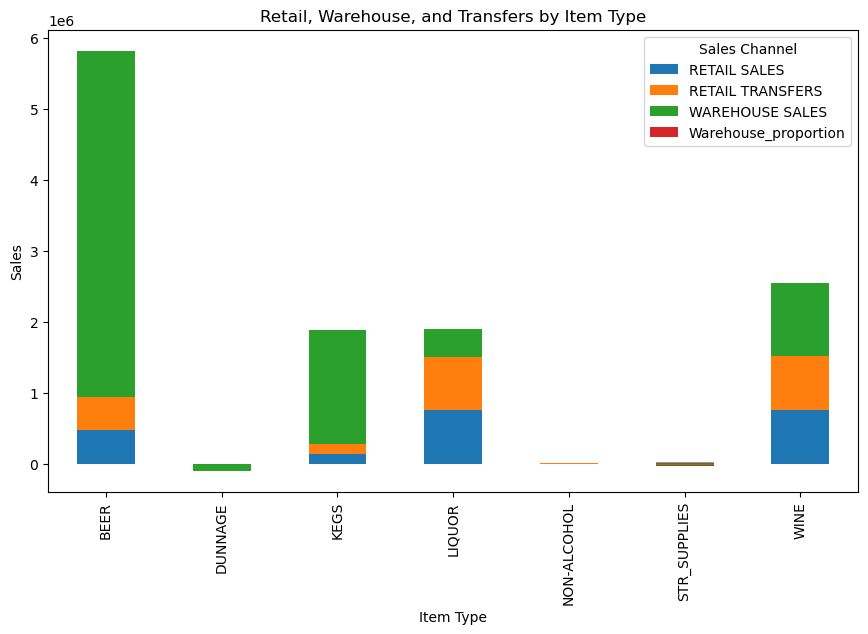

In [153]:
grouped_itemtypebysales.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Retail, Warehouse, and Transfers by Item Type")
plt.xlabel("Item Type")
plt.ylabel("Sales") 
plt.legend(title="Sales Channel")
plt.subplots_adjust(right=0.8)
plt.savefig("Retail, Warehouse, and Transfers by Item Type.png",dpi=300, bbox_inches="tight", pad_inches=0.2)

### Using heatmap for ITEM TYPE vs. Months showing total Total Net Sales Quantity. Will represent suppliers with seasonal sales patterns.

In [154]:
pivot_suppliersbymonthsales=df.pivot_table(index="ITEM TYPE",columns="MONTH",values="Total Net Sales Quanity", aggfunc="sum",fill_value=0)
pivot_suppliersbymonthsales

MONTH,1,2,3,4,5,6,7,8,9,10,11,12
ITEM TYPE,,,,,,,,,,,,
BEER,495560.91,310807.68,369073.80,185717.66,245630.84,463208.07,718601.86,473260.55,628931.08,417543.94,384941.75,190847.62
DUNNAGE,-12293.00,-7036.00,-6053.00,-4299.00,-4155.00,-8728.00,-10388.00,-8406.00,-10121.00,-9361.00,-8132.00,-3688.00
KEGS,166136.69,107050.45,124801.18,58780.75,77030.95,153897.60,229630.63,154400.87,204216.96,125391.09,135017.03,62563.30
LIQUOR,47981.94,30081.80,31663.80,14958.52,21507.80,37446.53,52616.43,34741.79,49622.54,30094.84,33115.15,20037.12
NON-ALCOHOL,131.93,80.77,28.09,1.87,138.56,102.59,63.54,146.11,185.87,61.60,109.11,86.01
STR_SUPPLIES,-2588.13,-1361.07,-640.43,-708.67,-358.39,-571.26,809.50,-9236.00,-471.25,-1455.41,-2687.72,-2274.15
WINE,123605.24,80217.48,83772.09,41098.42,50893.12,88376.30,123213.80,86262.72,124276.70,87648.69,95587.57,49890.30


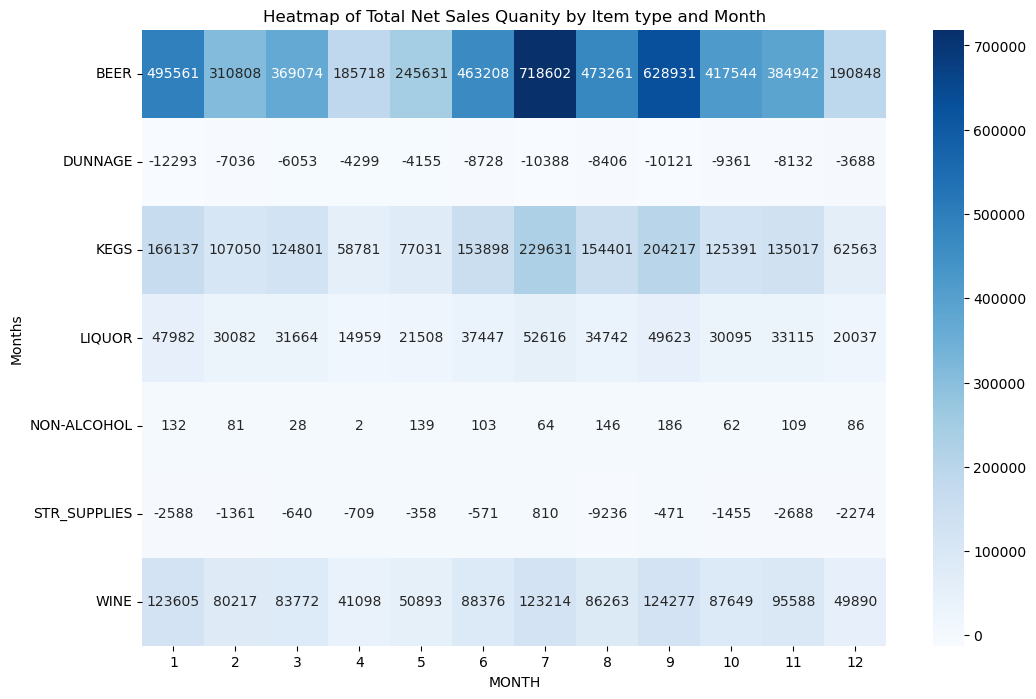

In [155]:
plt.figure(figsize=(12,8))
sns.heatmap(pivot_suppliersbymonthsales, cmap="Blues", annot=True, fmt=".0f")
plt.title("Heatmap of Total Net Sales Quanity by Item type and Month")
plt.ylabel("Item Type")
plt.ylabel("Months") 
plt.savefig("Heatmap of Total Net Sales Quanity by Item type and Month.png",dpi=300)